In [1]:
%load_ext autoreload
%autoreload 2

## Verify implementation of divergence theorem using `sectionate` and `regionmask`

In [2]:
# Import packages
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")

# Set figure font size
plt.rcParams.update({'font.size':12})

### Load data (here on `z` grid, but same approach works for any vertical coordinate)

In [3]:
dt = "6hourly"
rootdir = f'/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/ocean_{dt}/'
prefix = '19000101.ocean_'
grid = 'zstr'
suffixes = ['thck', 'heat', 'xtra']

og = xr.open_mfdataset(rootdir+prefix+"static.nc")
ds = xr.Dataset()
for suffix in suffixes:
    filename = f'{prefix}{dt}_{grid}_{suffix}*.nc'
    ds = xr.merge([ds, xr.open_mfdataset(rootdir+filename).isel(time=0)])
    
ds = ds.assign_coords({
    'dxCv': xr.DataArray(og['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(og['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
}).rename({'temp':'thetao'}) # add velocity face widths to calculate distances along the section

g_z = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                     'Y': {'center': 'yh', 'right': 'yq'},
                     'Z': {'inner': 'z_l', 'outer': 'z_i'} })

rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K

In [10]:
ds

<xarray.Dataset>
Dimensions:                         (xh: 97, yh: 105, z_l: 35, z_i: 36, nv: 2,
                                     xq: 97, yq: 105)
Coordinates:
  * xh                              (xh) float64 6.125 6.375 ... 29.88 30.12
  * yh                              (yh) float64 53.01 53.16 ... 65.48 65.56
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
    time                            object 1900-01-01 03:00:00
  * nv                              (nv) float64 1.0 2.0
  * xq                              (xq) float64 6.25 6.5 6.75 ... 30.0 30.25
  * yq                              (yq) float64 53.09 53.24 ... 65.52 65.6
    dxCv                            (xh, yq) float32 1.671e+04 ... 1.173e+04
    dyCu                            (xq, yh) float32 1.674e+04 ... 6.186e+03
Data variables: (12/27)
    thkcello                        (z_l, yh, xh) float32 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    dhdt                            (z_l, yh, xh) float64 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    dynamics_h_tendency             (z_l, yh, xh) float64 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    vert_remap_h_tendency           (z_l, yh, xh) float64 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    boundary_forcing_h_tendency     (z_l, yh, xh) float64 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    average_T1                      datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    ...                              ...
    drho_dT                         (z_l, yh, xh) float32 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    drho_dS                         (z_l, yh, xh) float32 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    umo                             (z_l, yh, xq) float32 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    vmo                             (z_l, yq, xh) float32 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>
    e                               (z_i, yh, xh) float32 dask.array<chunksize=(36, 105, 97), meta=np.ndarray>
    diabatic_forcing                (z_l, yh, xh) float64 dask.array<chunksize=(35, 105, 97), meta=np.ndarray>

#### Plot thickness budget for a single depth layer

Note the large degree of compensation between horizontal convergence and remapping tendencies.

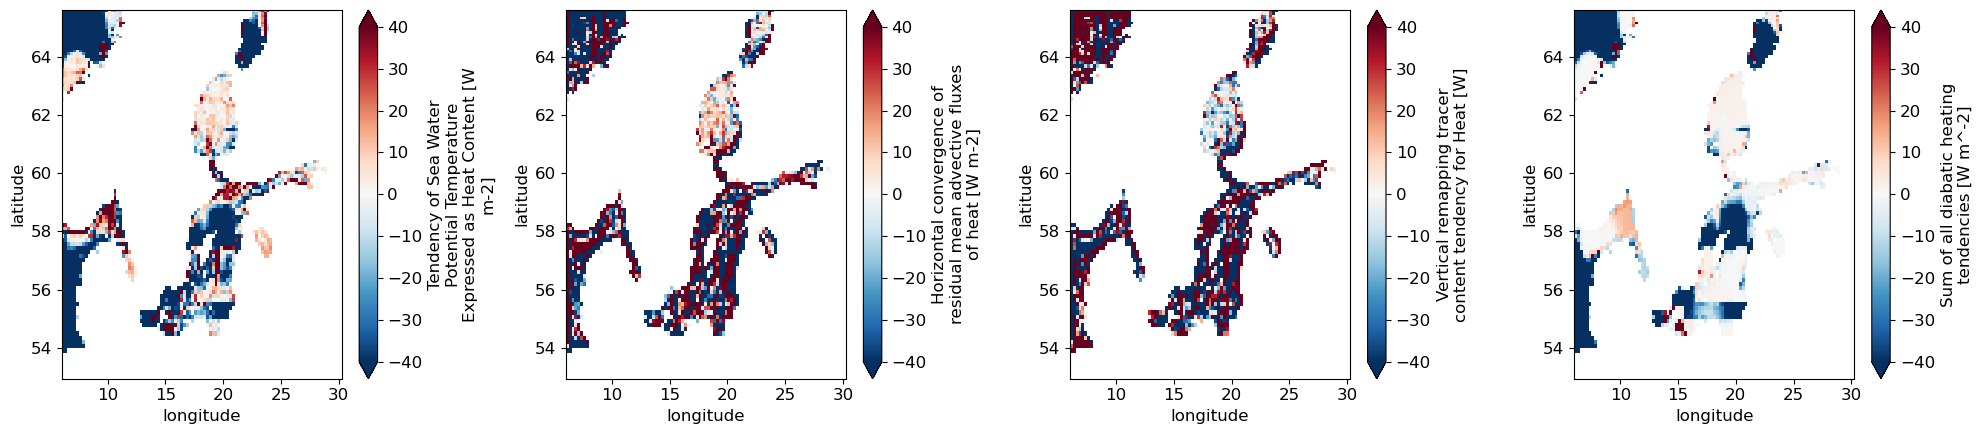

In [4]:
fig, axes = plt.subplots(1,4, figsize=(20, 4.5))
ds['opottemptend'].isel(z_l=3).plot(ax=axes[0], vmin=-40, vmax=40, cmap="RdBu_r")
ds['T_advection_xy'].isel(z_l=3).plot(ax=axes[1], vmin=-40, vmax=40, cmap="RdBu_r")
ds['Th_tendency_vert_remap'].isel(z_l=3).plot(ax=axes[2], vmin=-40, vmax=40, cmap="RdBu_r")
ds['diabatic_forcing'] = (ds['boundary_forcing_heat_tendency']+
 ds['internal_heat_heat_tendency']+
 ds['frazil_heat_tendency']+
 ds['opottemppmdiff']+
 ds['opottempdiff']
)
ds['diabatic_forcing'].attrs = {'long_name': "Sum of all diabatic heating tendencies", 'units': "W m^-2"}
ds['diabatic_forcing'].isel(z_l=3).plot(ax=axes[3], vmin=-40, vmax=40, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

#### Plot vertically-integrated thickness budget
Note the disproportionately large volume/mass inputs by river runoff at the boundaries of the Baltic sea, which is rapidly redistributed by horizontal ocean transports.

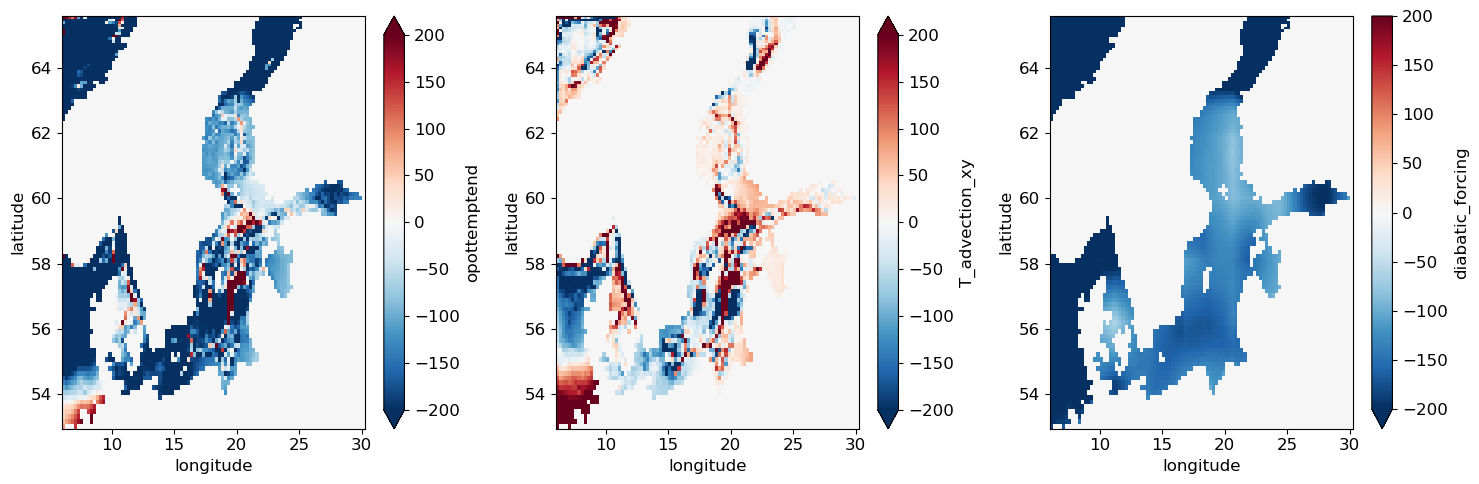

In [5]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
ds['opottemptend'].sum('z_l').plot(ax=axes[0], vmin=-200, vmax=200, cmap="RdBu_r")
ds['T_advection_xy'].sum('z_l').plot(ax=axes[1], vmin=-200, vmax=200, cmap="RdBu_r")
ds['diabatic_forcing'].sum('z_l').plot(ax=axes[2], vmin=-200, vmax=200, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

#### Define an arbitrary close sub-region of the domain defined by an irregular polygon

In [6]:
lons = np.array([13, 15, 20.5, 21.5, 19, 17])
lats = np.array([62., 53.5, 54.5, 57.1, 62, 59])
b = reg.conform_basin_to_ocean_grid(reg.Basin(lons, lats, "polygon"), og)

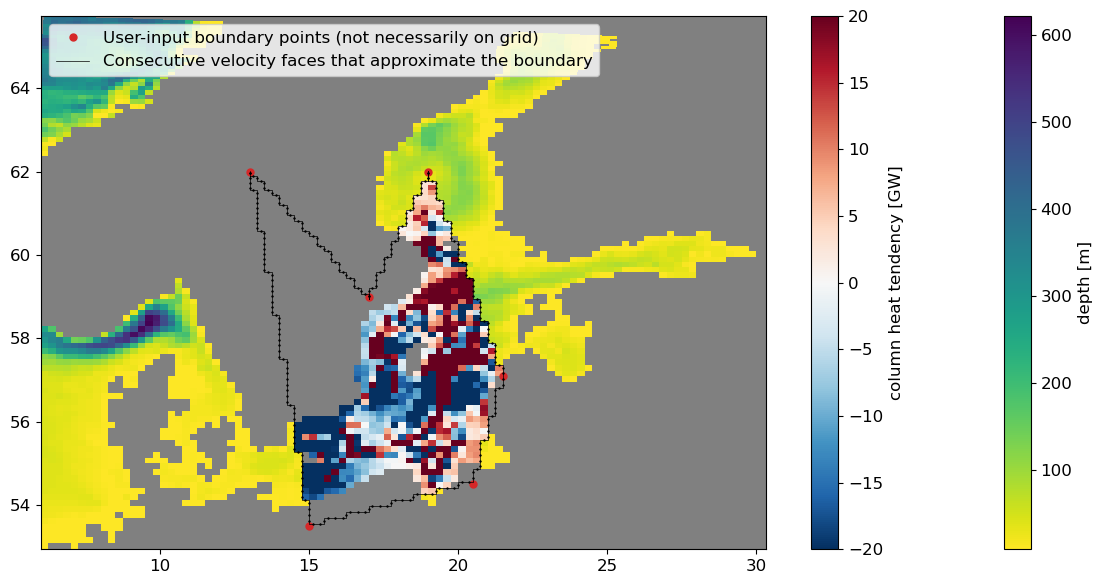

In [7]:
dheatdt_dynamics = (ds['T_advection_xy']*og['areacello']).sum('z_l')
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.)

plt.figure(figsize=(12, 6))
plt.subplot(facecolor="grey")
pc = plt.pcolormesh(
    og['geolon'], og['geolat'],
    dheatdt_dynamics.where(b.mask)*1e-9,
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
pc_dep = plt.pcolormesh(og['geolon'], og['geolat'], og.depth_ocean.where(~b.mask), cmap="viridis_r")
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot(b.lons, b.lats, "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(b.lons_uv, b.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left")
plt.tight_layout()

#### Verifying the 2D Divergence theorem for area integrals over complicated sub-domains

The extensive heat (or, equivalently, potential temperature) equation in MOM6 is given by
\begin{equation}
C_{p}\rho_{0}\left[\partial_{t} (\Theta h) + \nabla_{r} \cdot (\mathbf{u} \Theta h) + \delta_{r}(\Theta z_{r} \dot{r}) = J_{\Theta}\right].
\end{equation}

Integrating in $z$ and over a region $(x,y)\in \mathcal{R}$ (like the sub-domain defined above), the heat budget is
\begin{equation}
\partial_{t} H = \iint_{\mathcal{R}} - \nabla \cdot \mathbf{\mathcal{H}} \, \text{d}A + C_{p}\rho_{0}J_{\Theta}. \quad\quad\text{where }\mathbf{\mathcal{H}} \equiv C_{p}\rho_{0}\int \mathbf{u} \Theta h \,\text{d}z\quad\text{ is the vertically-integrated heat flux.}
\end{equation}

Applying the divergence theorem, we can rewrite
\begin{equation}
\iint_{\mathcal{R}} -\nabla \cdot \mathbf{\mathcal{H}} \, \text{d}A = \int_{\partial \mathcal{R}}  \mathbf{\mathcal{H}} \cdot \mathbf{n}_{in} \,\text{d}l \equiv \Psi_{\Theta}, 
\end{equation}
with $\Psi_{\Theta}$ the horizontally convergent heat transport. We evaluate the LHS area integral by applying a mask to the diagnosed dynamical heat tendency term and the RHS boundary integral term by accumulating normal heat fluxes (with positive velocities defined inwards) along the region's boundary.

In [8]:
advective_heating = dheatdt_dynamics.where(b.mask).sum(['xh', 'yh']).values # LHS

symmetric = og['geolon'].shape == og['geolon_c'].shape
convergent_transport = sec.convergent_transport(ds, b.i, b.j, symmetric, layer="z_l", interface="z_i")['conv_mass_transport']
specific_heat = Cp*sec.extract_tracer(ds['thetao'], b.i, b.j, symmetric)
convergent_heat_transport = (convergent_transport*specific_heat).cumsum("sect").sel(z_l=ds.z_l[::-1]).cumsum('z_l').sel(z_l=ds.z_l[::-1]).compute() # kg/s*K*(J/kg/K) = W
convergent_heat_transport_net = convergent_heat_transport.isel(sect=-1, z_l=-1).values # RHS

print(f"Heat flux relative error = {np.round((convergent_heat_transport_net - advective_heating)/advective_heating*100, 4)}%")

Heat flux relative error = 0.3282%


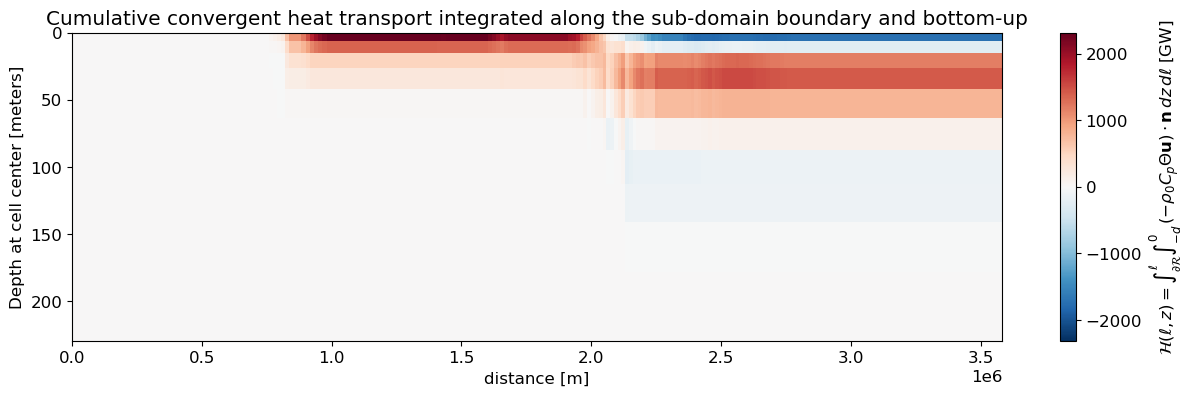

In [9]:
plt.figure(figsize=(15, 4))
pc = (convergent_heat_transport*1e-9).swap_dims({'sect':'distance'}).plot(x="distance")
plt.ylim(og.where(b.mask).depth_ocean.max(), 0)
plt.title("Cumulative convergent heat transport integrated along the sub-domain boundary and bottom-up")
pc.colorbar.set_label(r"$\mathcal{H}(\ell, z) = \int_{\partial \mathcal{R}}^{\ell} \int_{-d}^{0} \, (- \rho_{0} C_{p} \Theta \mathbf{u})  \cdot \mathbf{n} \,dz\,d\ell$ [GW]")